In [19]:

%load_ext autoreload
%autoreload 

import os
import sys
import pandas as pd
sys.path.append(os.path.join('..', 'src'))
import helper
import plots
import metrics
from run_analysis import FairnessAnalyzer
from model_fitting import logistic_model




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
seeds = [42, 100, 111, 123, 789, 999, 1234, 2024, 3456, 5678]

# seeds = [42]

# For data evaluation


In [21]:

analyzer_data = FairnessAnalyzer(
    sensitive_attrs=["Gender", "Race"],
    outcome_col="Y",
    base_data_path="../generated_data",
)

all_results = {}
for seed in seeds:
    res = analyzer_data.analyzer_seed(seed, verbose=True)
    all_results[seed] = res
results_summary = helper.create_summary_dataframe(all_results)


🎯 Analyzing seed 42...
🎯 Analyzing seed 100...
🎯 Analyzing seed 111...
🎯 Analyzing seed 123...
🎯 Analyzing seed 789...
🎯 Analyzing seed 999...
🎯 Analyzing seed 1234...
🎯 Analyzing seed 2024...
🎯 Analyzing seed 3456...
🎯 Analyzing seed 5678...


#### Plot results for the intersectional metric on the data

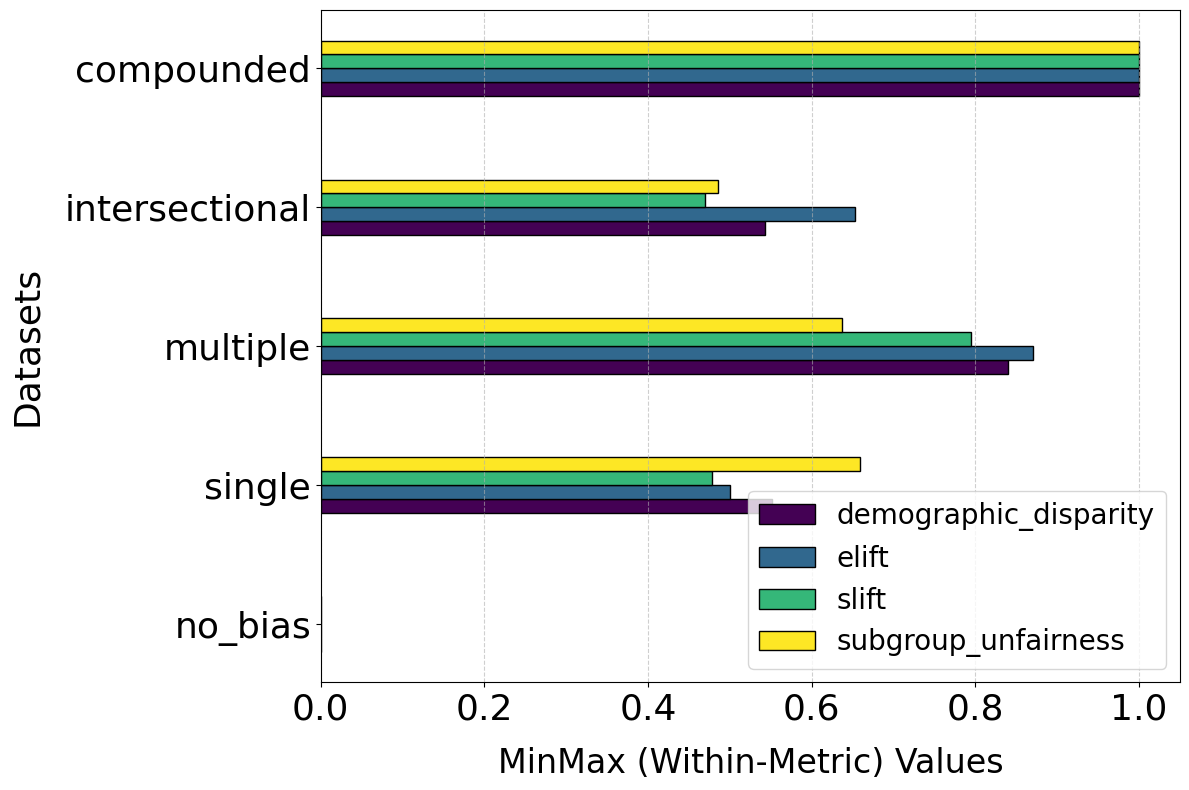

In [22]:
plots.plot_metrics_from_summary(results_summary, 
                    output_file='../images/intersectional_fairness_metrics_on_data.pdf', 
                             data_type='Generated Data', dpi=800, 
                             scalar_type='MinMax', metrics_to_scale=None, 
                             apply_scaling=True, force_scaling_type='within')

# For classifier evaluation

In [23]:
get_summary = False
split_data = True
outcome_col = 'y_true'
prediction_col = 'y_hat'
# Store all classifier results across seeds and scenarios
all_classifier_results = {}

for seed in seeds:
    print(f"\n🎯 Processing classifiers for seed {seed}...")
    seed_results = {}
    
    # Load data for this seed using the analyzer
    seed_data = analyzer_data.analyzer_seed(seed, verbose=False)
    
    # For each scenario, fit classifier and evaluate
    for scenario_name in seed_data.keys():
        # Load the actual data file for this scenario and seed
        data_path = f"../generated_data/seed_{seed}"
        scenario_file = f"{scenario_name}_discrimination_seed_{seed}.csv"
        if scenario_name == 'no_bias':
            scenario_file = f"no_discrimination_seed_{seed}.csv"
        
        try:
            scenario_data = pd.read_csv(os.path.join(data_path, scenario_file))
            
            # Fit classifier
            df_with_predictions, classifier_metrics = logistic_model(
                scenario_data, get_summary=get_summary, split_data=split_data, random_seed=seed
            )
            
            # Evaluate fairness metrics
            fairness_results, subgroup_rates = metrics.evaluation_classifier(
                df_with_predictions, ["Gender", "Race"], outcome_col, prediction_col
            )
            
            seed_results[scenario_name] = fairness_results
            
        except Exception as e:
            print(f"  ❌ {scenario_name}: Error - {e}")
            seed_results[scenario_name] = {}
    
    all_classifier_results[seed] = seed_results

# Create summary for classifier results
classifier_summary = helper.create_summary_dataframe(all_classifier_results)


🎯 Processing classifiers for seed 42...
Optimization terminated successfully.
         Current function value: 0.132138
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.136434
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.150832
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.147039
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.150227
         Iterations 10

🎯 Processing classifiers for seed 100...
Optimization terminated successfully.
         Current function value: 0.155510
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.159034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.160925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.132853
         Iter

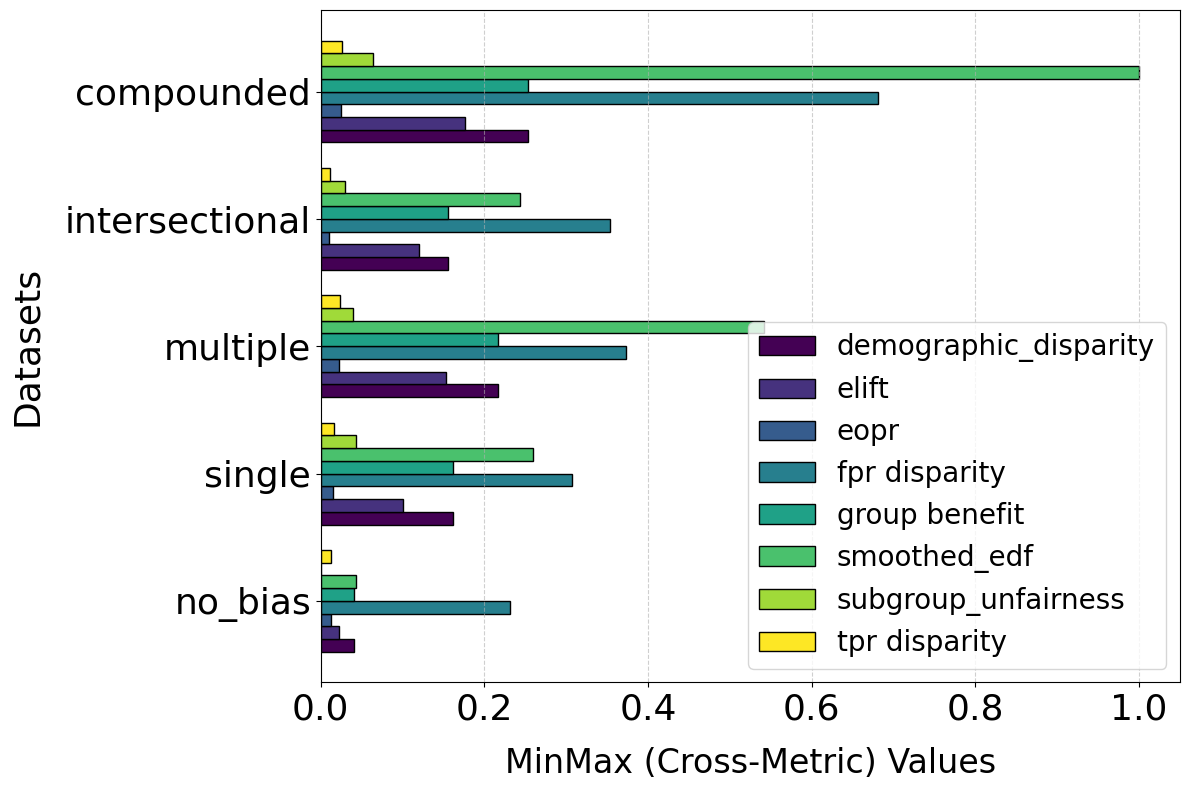

In [25]:
# Plot classifier fairness metrics
plots.plot_metrics_from_summary(classifier_summary, 
                    output_file='../images/intersectional_fairness_metrics_classifier.pdf', 
                    data_type='Classifier Results', dpi=800, 
                    scalar_type='MinMax', metrics_to_scale=None, 
                    apply_scaling=True, force_scaling_type='across')